In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../modules')
from FSC import GenerationDiscreteObs as FSC_DiscreteObs
from FSC import InferenceDiscreteObs as FSC_InferenceDiscreteObs
import ObsModels 

# Finite State Controller with $M = 2$, $A = 2$, $Y = 2$

# Observations

In [3]:
NStepsObs = 100
NTraj = 100
Y = 2
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)
observations.shape

(100, 100)

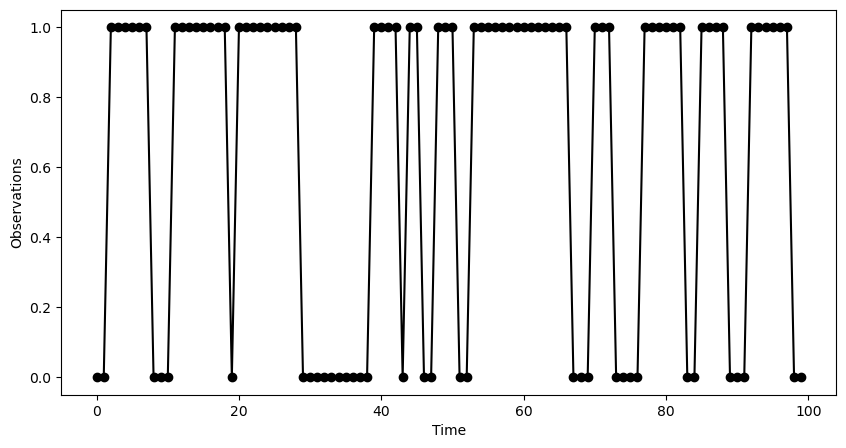

In [4]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(observations[0], 'o', label='Trajectory 0', color='black')
plt.plot(observations[0], color='black', label='Trajectory 0')
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

## Structured transition matrix

In [5]:
M = 2
A = 2

ThetaFollowSwitch = np.array([[[[10, 0.01], [0.01, 0.01]],
                               [[0.01, 0.01], [0.01, 10]]],
                              [[[0.01, 0.01], [0.01, 10]],
                               [[10, 0.01], [0.01, 0.01]]]])


Psi = np.array([1, 2])

FSC = FSC_DiscreteObs(ThetaFollowSwitch, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


In [6]:
FSC.load_observations(observations[:100])

In [7]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

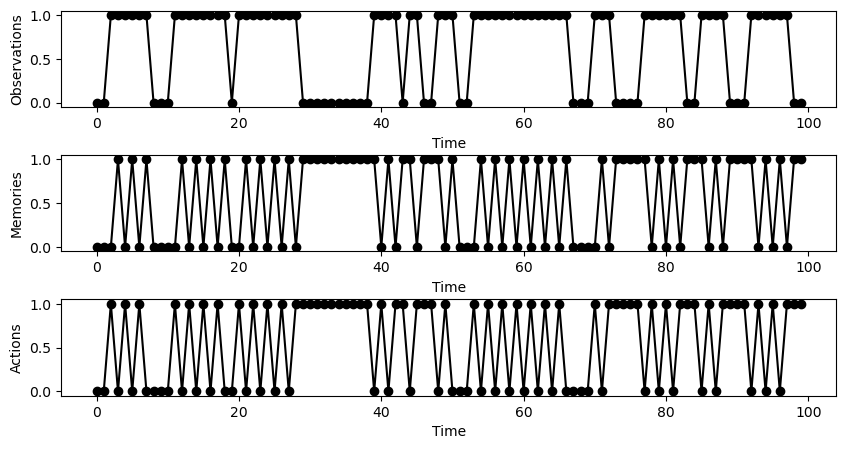

In [8]:
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = FSC.plot_trajectory(trj, Time)

In [9]:
FSC.evaluate_nloglikelihood(trajectories[0])

/mnt/DAA0C4FEA0C4E1DD/Users/gnico/github/InferenceFSCs/notebooks/../modules/FSC.py:403: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  m = transition_probs @ rho


1.326846889857264

### Inference

In [10]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123)
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(72.7584, device='cuda:0', grad_fn=<SubBackward0>)

In [11]:
%%time
tloss, vloss = FSC_tofit.optimize(NEpochs = 10, NBatch = 20, lr = 0.2, gamma = 0.9)

Training with 80 trajectories and validating with 20 trajectories.
Epoch 1 - Training loss: 68.68953247070313, Validation loss: 69.21722068786622 - Learning rate: 0.2
Epoch 2 - Training loss: 54.65171966552734, Validation loss: 44.57729568481445 - Learning rate: 0.18000000000000002
Epoch 3 - Training loss: 28.53373603820801, Validation loss: 19.248954486846923 - Learning rate: 0.16200000000000003
Epoch 4 - Training loss: 11.31726951599121, Validation loss: 7.687731790542602 - Learning rate: 0.14580000000000004
Epoch 5 - Training loss: 4.893867492675781, Validation loss: 3.8702343344688415 - Learning rate: 0.13122000000000003
Epoch 6 - Training loss: 2.733241415023804, Validation loss: 2.52979861497879 - Learning rate: 0.11809800000000004
Epoch 7 - Training loss: 1.9055452823638916, Validation loss: 1.9768841087818145 - Learning rate: 0.10628820000000004
Epoch 8 - Training loss: 1.5270543813705444, Validation loss: 1.713123095035553 - Learning rate: 0.09565938000000004
Epoch 9 - Trainin

### Comparison

In [12]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


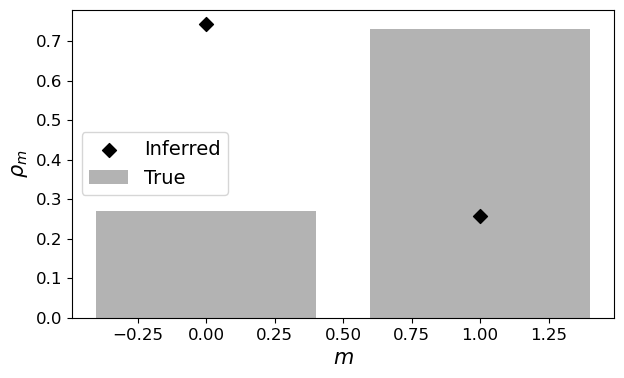

In [13]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(np.arange(M), FSC.rho, color = "dimgray", alpha = 0.5, label = "True")
ax.scatter(np.arange(M), FSC_inferred.rho, color = "black", marker = "D", s = 50, label = "Inferred")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize = 14)

plt.show()

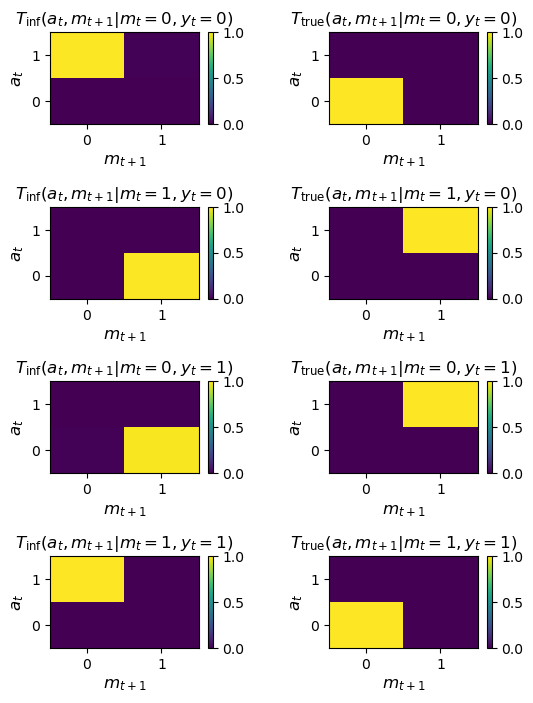

In [14]:
fig, axs = plt.subplots(Y*M, 2, figsize=(6,8))
plt.subplots_adjust(hspace = 0.9, wspace=0.5)
for a in axs.flatten():
    a.set_xticks(FSC.MemSpace)
    a.set_yticks(FSC.ActSpace)
    a.set_xlabel("$m_{t+1}$", fontsize = 12)
    a.set_ylabel("$a_t$", fontsize = 12)

c = 0
for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m, m in enumerate(FSC_inferred.MemSpace):
        im_inf = axs[c, 0].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, FSC_inferred.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)
        im_true = axs[c, 1].pcolormesh(FSC.MemSpace, FSC.ActSpace, FSC.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)

        axs[c, 0].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")
        axs[c, 1].set_title(f"$T_\\mathrm{{true}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[c, 0])
        cbar_true = fig.colorbar(im_true, ax=axs[c, 1])

        c += 1

plt.show()

In [15]:
FSC_inferred.load_observations(observations)

In [16]:
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)

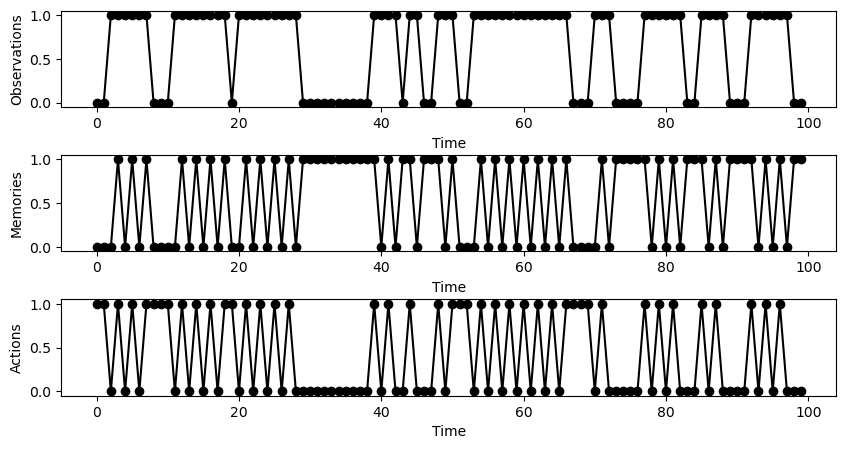

In [17]:
idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

# $M = 2$, $A = 2$, $Y = 2$, random

In [18]:
M = 2
A = 2

np.random.seed(7)

Theta = np.random.randn(Y, M, M, A)

Psi = np.random.randn(M)

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


In [19]:
FSC.load_observations(observations)

In [20]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

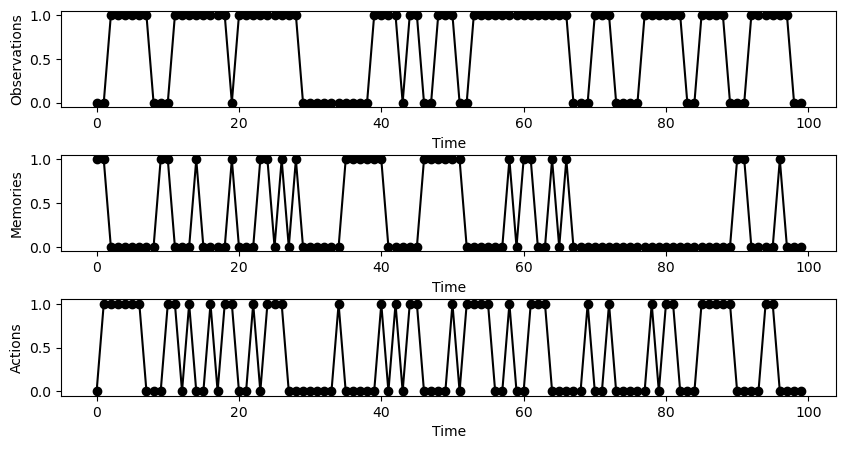

In [21]:
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = FSC.plot_trajectory(trj, Time)

In [22]:
FSC.evaluate_nloglikelihood(trajectories[0])

65.76301573204904

### Inference

In [23]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123456789)
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(84.2875, device='cuda:0', grad_fn=<SubBackward0>)

In [24]:
%%time
tloss, vloss = FSC_tofit.optimize(NEpochs = 30, NBatch = 20, lr = 0.01, gamma = 0.99)

Training with 80 trajectories and validating with 20 trajectories.
Epoch 1 - Training loss: 75.18379516601561, Validation loss: 74.90181007385254 - Learning rate: 0.01
Epoch 2 - Training loss: 74.0925506591797, Validation loss: 73.90178413391114 - Learning rate: 0.0099
Epoch 3 - Training loss: 73.12212677001953, Validation loss: 72.99537658691406 - Learning rate: 0.009801
Epoch 4 - Training loss: 72.23617401123047, Validation loss: 72.17919921875 - Learning rate: 0.00970299
Epoch 5 - Training loss: 71.45434265136718, Validation loss: 71.44747619628906 - Learning rate: 0.0096059601
Epoch 6 - Training loss: 70.74478912353516, Validation loss: 70.798313331604 - Learning rate: 0.009509900499
Epoch 7 - Training loss: 70.12118835449219, Validation loss: 70.21682815551758 - Learning rate: 0.00941480149401
Epoch 8 - Training loss: 69.56715393066406, Validation loss: 69.7001853942871 - Learning rate: 0.0093206534790699
Epoch 9 - Training loss: 69.07694244384766, Validation loss: 69.243852043151

### Comparison

In [25]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


In [28]:
rho_sort = [1,0]

psi_sorted = FSC_inferred.psi[rho_sort]
theta_sorted = np.zeros_like(FSC_inferred.theta)

for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m1, m1 in enumerate(FSC_inferred.MemSpace):
        for idx_m2, m2 in enumerate(FSC_inferred.MemSpace):
            for idx_a, a in enumerate(FSC_inferred.ActSpace):
                theta_sorted[idx_y, idx_m1, idx_m2, idx_a] = FSC_inferred.theta[idx_y, rho_sort[idx_m1], rho_sort[idx_m2], idx_a]

FSC_inferred.load_theta(theta_sorted)
FSC_inferred.load_psi(psi_sorted)

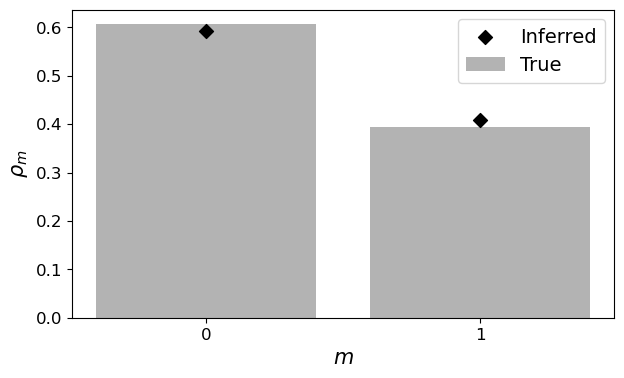

In [29]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(np.arange(M), FSC.rho, color = "dimgray", alpha = 0.5, label = "True")
ax.scatter(np.arange(M), FSC_inferred.rho, color = "black", marker = "D", s = 50, label = "Inferred")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xticks(np.arange(M))

plt.legend(fontsize = 14)

plt.show()

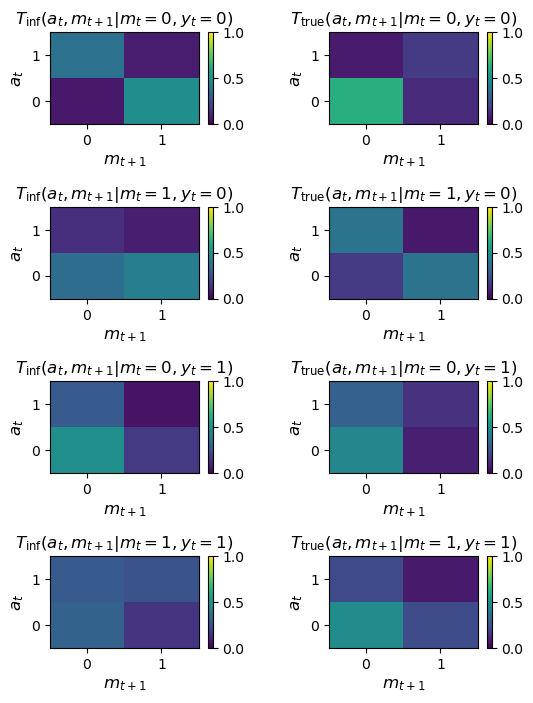

In [30]:
fig, axs = plt.subplots(Y*M, 2, figsize=(6,8))
plt.subplots_adjust(hspace = 0.9, wspace=0.5)
for a in axs.flatten():
    a.set_xticks(FSC.MemSpace)
    a.set_yticks(FSC.ActSpace)
    a.set_xlabel("$m_{t+1}$", fontsize = 12)
    a.set_ylabel("$a_t$", fontsize = 12)

c = 0
for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m, m in enumerate(FSC_inferred.MemSpace):
        im_inf = axs[c, 0].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, FSC_inferred.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)
        im_true = axs[c, 1].pcolormesh(FSC.MemSpace, FSC.ActSpace, FSC.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)

        axs[c, 0].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")
        axs[c, 1].set_title(f"$T_\\mathrm{{true}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[c, 0])
        cbar_true = fig.colorbar(im_true, ax=axs[c, 1])

        c += 1

plt.show()

In [31]:
FSC_inferred.load_observations(observations)

In [32]:
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)

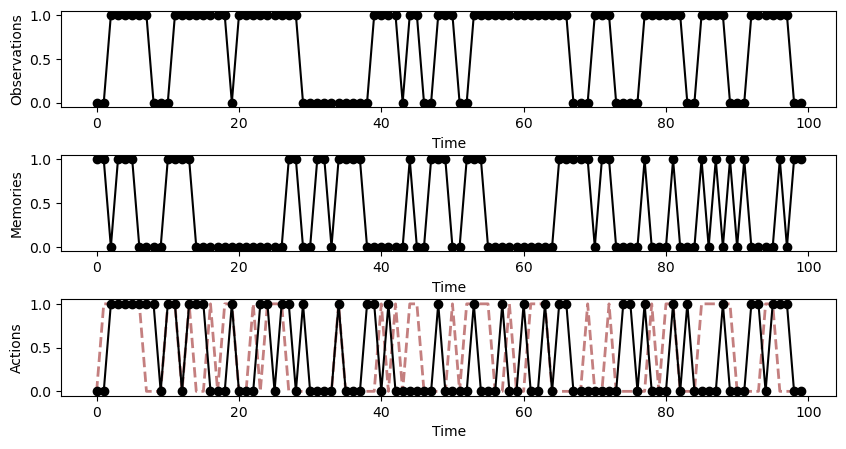

In [42]:
idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

ax[2].plot(trajectories[idx_trj]["actions"], label = "True", color = "darkred", zorder = -1, alpha = 0.5, lw = 2, ls = "--")

# $M = 4$, $A = 2$, $Y = 3$, random - harder example

# Observations

In [66]:
NStepsObs = 300
NTraj = 250
Y = 3
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 25*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 1)
observations.shape

(250, 300)

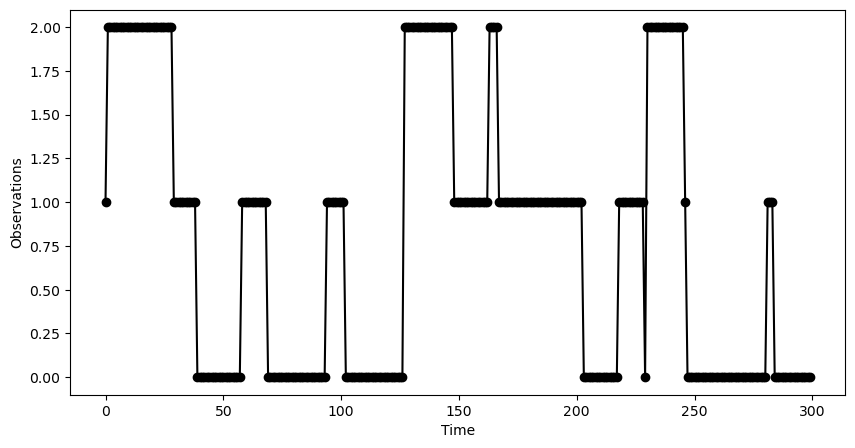

In [67]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(observations[0], 'o', label='Trajectory 0', color='black')
plt.plot(observations[0], color='black', label='Trajectory 0')
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

In [68]:
M = 4
A = 2

np.random.seed(42)

Theta = np.random.randn(Y, M, M, A)

Psi = np.random.randn(M)

rho_sort = np.argsort(np.exp(Psi)/np.sum(np.exp(Psi)))
Psi = Psi[rho_sort]

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 4 memory states, 2 actions, and 3 observations.


In [69]:
FSC.load_observations(observations)

In [70]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

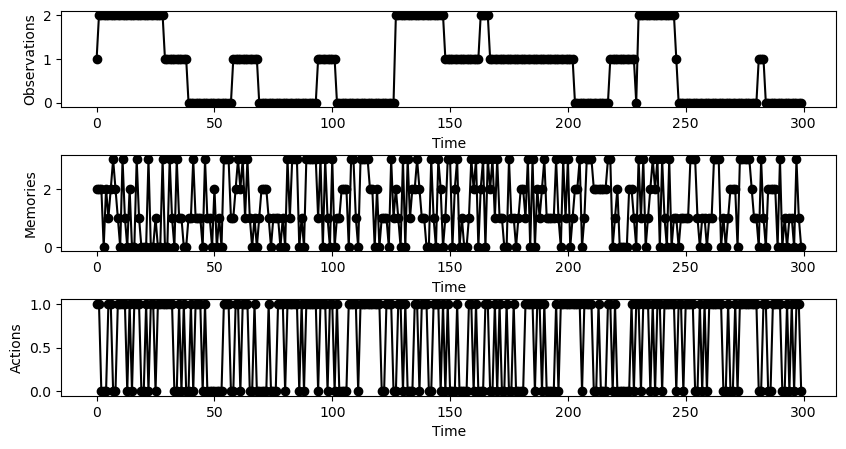

In [71]:
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = FSC.plot_trajectory(trj, Time)

In [72]:
nLL = 0

for trj in trajectories:
    nLL += FSC.evaluate_nloglikelihood(trj)

nLL/len(trajectories)

202.79039220422675

### Inference

In [73]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123456789)
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(208.0503, device='cuda:0', grad_fn=<SubBackward0>)

In [74]:
%%time
tloss, vloss = FSC_tofit.optimize(NEpochs = 30, NBatch = 50, lr = 0.01, gamma = 0.99)

Training with 200 trajectories and validating with 50 trajectories.
Epoch 1 - Training loss: 208.76650390625, Validation loss: 208.42257446289062 - Learning rate: 0.01
Epoch 2 - Training loss: 207.57291503906248, Validation loss: 207.3573861694336 - Learning rate: 0.0099
Epoch 3 - Training loss: 206.6007080078125, Validation loss: 206.4825064086914 - Learning rate: 0.009801
Epoch 4 - Training loss: 205.7885107421875, Validation loss: 205.79060272216796 - Learning rate: 0.00970299
Epoch 5 - Training loss: 205.17874999999998, Validation loss: 205.25308624267578 - Learning rate: 0.0096059601
Epoch 6 - Training loss: 204.6982763671875, Validation loss: 204.85404022216798 - Learning rate: 0.009509900499
Epoch 7 - Training loss: 204.352587890625, Validation loss: 204.56727844238281 - Learning rate: 0.00941480149401
Epoch 8 - Training loss: 204.0936865234375, Validation loss: 204.36370849609375 - Learning rate: 0.0093206534790699
Epoch 9 - Training loss: 203.90042968749998, Validation loss: 2

### Comparison

In [75]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

rho_sort = np.argsort(FSC_inferred.rho)

psi_sorted = FSC_inferred.psi[rho_sort]
theta_sorted = np.zeros_like(FSC_inferred.theta)

for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m1, m1 in enumerate(FSC_inferred.MemSpace):
        for idx_m2, m2 in enumerate(FSC_inferred.MemSpace):
            for idx_a, a in enumerate(FSC_inferred.ActSpace):
                theta_sorted[idx_y, idx_m1, idx_m2, idx_a] = FSC_inferred.theta[idx_y, rho_sort[idx_m1], rho_sort[idx_m2], idx_a]

FSC_inferred.load_theta(theta_sorted)
FSC_inferred.load_psi(psi_sorted)

Initializing FSC with 4 memory states, 2 actions, and 3 observations.


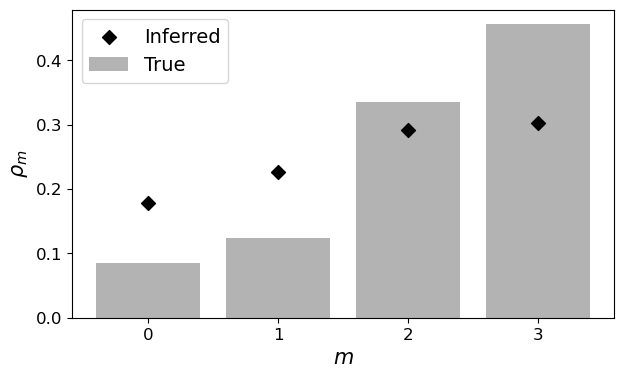

In [76]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(np.arange(M), FSC_inferred.rho, color = "dimgray", alpha = 0.5, label = "True")
ax.scatter(np.arange(M), FSC.rho, color = "black", marker = "D", s = 50, label = "Inferred")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xticks(np.arange(M))

plt.legend(fontsize = 14)

plt.show()

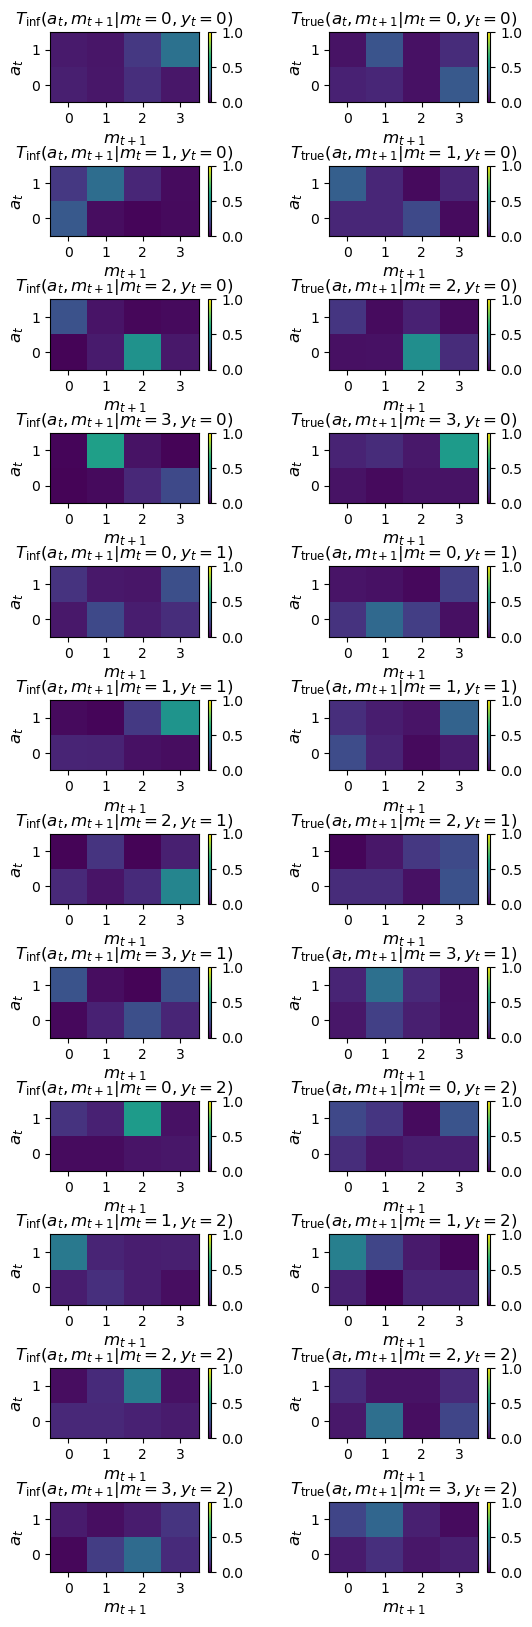

In [77]:
fig, axs = plt.subplots(Y*M, 2, figsize=(6,20))
plt.subplots_adjust(hspace = 0.9, wspace=0.5)
for a in axs.flatten():
    a.set_xticks(FSC.MemSpace)
    a.set_yticks(FSC.ActSpace)
    a.set_xlabel("$m_{t+1}$", fontsize = 12)
    a.set_ylabel("$a_t$", fontsize = 12)

c = 0
for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m, m in enumerate(FSC_inferred.MemSpace):
        im_inf = axs[c, 0].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, FSC_inferred.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)
        im_true = axs[c, 1].pcolormesh(FSC.MemSpace, FSC.ActSpace, FSC.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)

        axs[c, 0].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")
        axs[c, 1].set_title(f"$T_\\mathrm{{true}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[c, 0])
        cbar_true = fig.colorbar(im_true, ax=axs[c, 1])

        c += 1

plt.show()

In [78]:
FSC_inferred.load_observations(observations)

In [79]:
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)

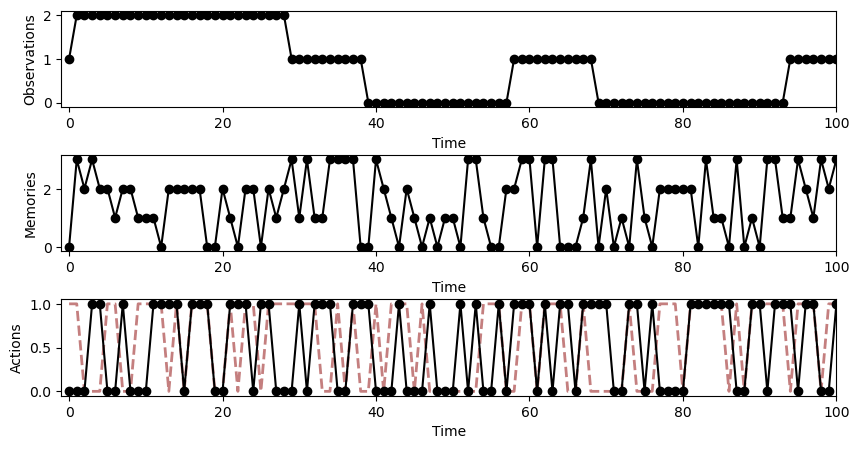

In [82]:
idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

ax[2].plot(trajectories[idx_trj]["actions"], label = "True", color = "darkred", zorder = -1, alpha = 0.5, lw = 2, ls = "--")

for a in ax:
    a.set_xlim(-1, 100)

# $M = 2$, $A = 2$, $Y = 3$ with structured transition matrix

In [91]:
NStepsObs = 100
NTraj = 100
Y = 3
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 5*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 42)
observations.shape

(100, 100)

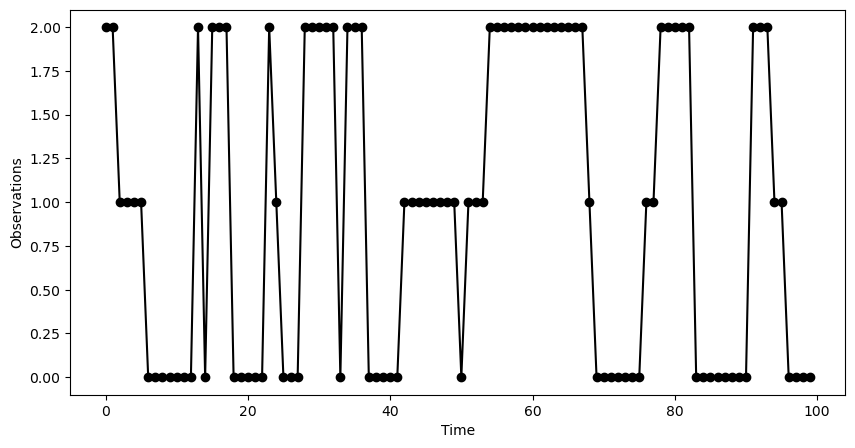

In [92]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(observations[0], 'o', label='Trajectory 0', color='black')
plt.plot(observations[0], color='black', label='Trajectory 0')
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

In [93]:
M = 2
A = 2

ThetaFollowSwitchFollow = np.zeros((Y, M, M, A))

ThetaFollowSwitchFollow[0] = np.array([[[1, 0.1], [0.1, 0.1]],
                                      [[1.1, 0.1], [0.1, 0.1]]])

ThetaFollowSwitchFollow[2] = np.array([[[0.1, 0.1], [0.1, 1]],
                                      [[0.1,0.1], [0.1, 1.2]]])

ThetaFollowSwitchFollow[1] = np.array([[[0.5, 0.6], [1.3, 5]],
                                       [[1.3, 1], [0.6, 0.1]]])

Psi = np.array([1., 1.5])

FSC = FSC_DiscreteObs(ThetaFollowSwitchFollow, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 3 observations.


In [94]:
FSC.rho

array([0.37754067, 0.62245933])

In [95]:
FSC.load_observations(observations)

In [96]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

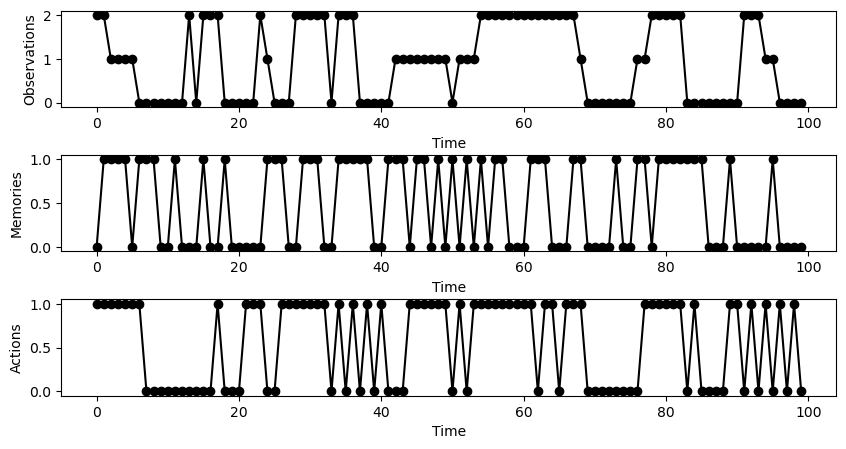

In [97]:
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = FSC.plot_trajectory(trj, Time)

In [98]:
FSC.evaluate_nloglikelihood(trajectories[0])

60.039326169866754

### Inference

In [99]:
M = 2
A = 2
Y = 3

In [100]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123456789)
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(102.4722, device='cuda:0', grad_fn=<SubBackward0>)

In [101]:
tloss, vloss = FSC_tofit.optimize(NEpochs = 30, NBatch = 20, lr = 0.01, gamma = 0.99)

Training with 80 trajectories and validating with 20 trajectories.
Epoch 1 - Training loss: 92.4817413330078, Validation loss: 93.33600730895996 - Learning rate: 0.01
Epoch 2 - Training loss: 90.70783233642578, Validation loss: 91.56444969177247 - Learning rate: 0.0099
Epoch 3 - Training loss: 89.02827758789061, Validation loss: 89.88157768249512 - Learning rate: 0.009801
Epoch 4 - Training loss: 87.42486114501953, Validation loss: 88.29156150817872 - Learning rate: 0.00970299
Epoch 5 - Training loss: 85.93750762939453, Validation loss: 86.78218078613281 - Learning rate: 0.0096059601
Epoch 6 - Training loss: 84.52496337890625, Validation loss: 85.35863037109375 - Learning rate: 0.009509900499
Epoch 7 - Training loss: 83.19981994628907, Validation loss: 84.0120132446289 - Learning rate: 0.00941480149401
Epoch 8 - Training loss: 81.94445343017578, Validation loss: 82.74431533813477 - Learning rate: 0.0093206534790699
Epoch 9 - Training loss: 80.77196807861328, Validation loss: 81.5528663

### Comparison

In [102]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

rho_sort = [1,0]

psi_sorted = FSC_inferred.psi[rho_sort]
theta_sorted = np.zeros_like(FSC_inferred.theta)

for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m1, m1 in enumerate(FSC_inferred.MemSpace):
        for idx_m2, m2 in enumerate(FSC_inferred.MemSpace):
            for idx_a, a in enumerate(FSC_inferred.ActSpace):
                theta_sorted[idx_y, idx_m1, idx_m2, idx_a] = FSC_inferred.theta[idx_y, rho_sort[idx_m1], rho_sort[idx_m2], idx_a]

FSC_inferred.load_theta(theta_sorted)
FSC_inferred.load_psi(psi_sorted)

Initializing FSC with 2 memory states, 2 actions, and 3 observations.


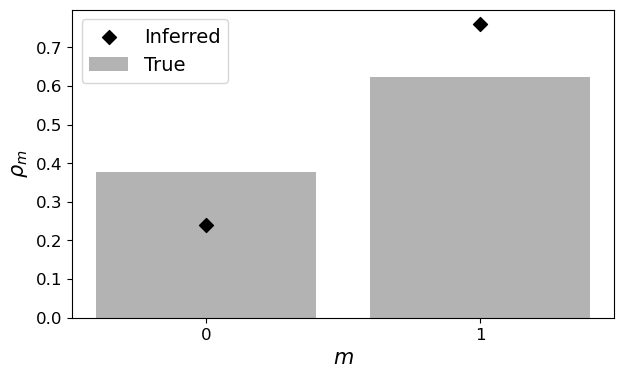

In [103]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(np.arange(M), FSC.rho, color = "dimgray", alpha = 0.5, label = "True")
ax.scatter(np.arange(M), FSC_inferred.rho, color = "black", marker = "D", s = 50, label = "Inferred")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xticks(np.arange(M))

plt.legend(fontsize = 14)

plt.show()

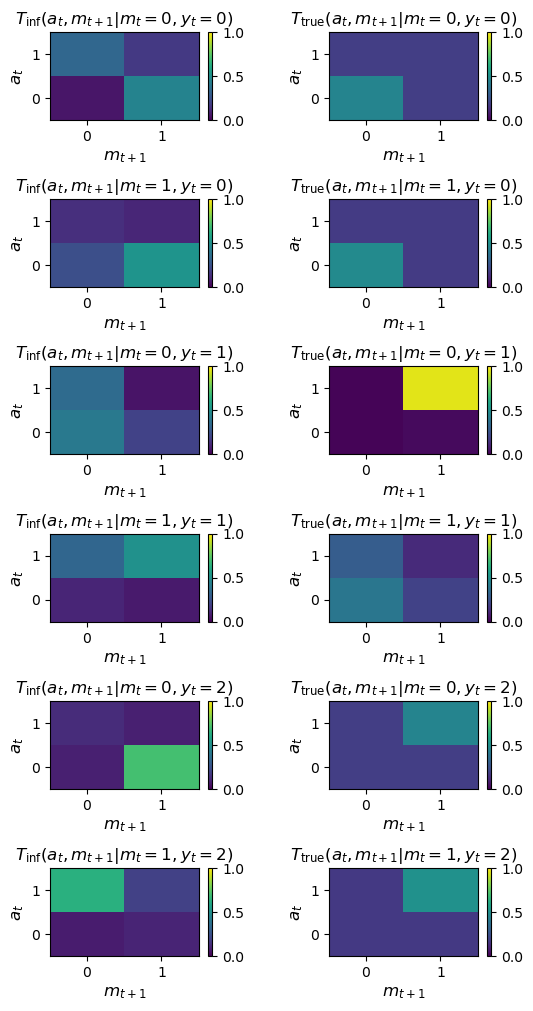

In [104]:
fig, axs = plt.subplots(Y*M, 2, figsize=(6,12))
plt.subplots_adjust(hspace = 0.9, wspace=0.5)
for a in axs.flatten():
    a.set_xticks(FSC.MemSpace)
    a.set_yticks(FSC.ActSpace)
    a.set_xlabel("$m_{t+1}$", fontsize = 12)
    a.set_ylabel("$a_t$", fontsize = 12)

c = 0
for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m, m in enumerate(FSC_inferred.MemSpace):
        im_inf = axs[c, 0].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, FSC_inferred.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)
        im_true = axs[c, 1].pcolormesh(FSC.MemSpace, FSC.ActSpace, FSC.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)

        axs[c, 0].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")
        axs[c, 1].set_title(f"$T_\\mathrm{{true}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[c, 0])
        cbar_true = fig.colorbar(im_true, ax=axs[c, 1])

        c += 1

plt.show()

In [105]:
FSC_inferred.load_observations(observations)

In [106]:
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)

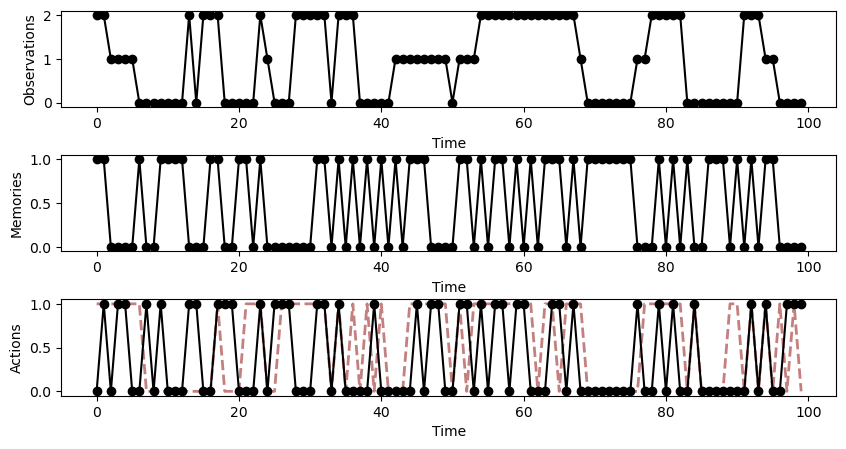

In [107]:
idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

ax[2].plot(trajectories[idx_trj]["actions"], label = "True", color = "darkred", zorder = -1, alpha = 0.5, lw = 2, ls = "--")
